##### Copyright 2020 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [6]:
 # ? Define a class named Autoencoder which inherits from the Model class in TensorFlow.
class Autoencoder(Model):
  # The initializer method for the Autoencoder class. It is called when a new instance is created.
  # * 'latent_dim' is a parameter that specifies the size of the latent space, and 'shape' is the shape of the input data.
  def __init__(self, latent_dim, shape):
    # Calls the constructor of the parent class Model to handle setup.
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    # ? - Creates the encoder part of the autoencoder as a Sequential model. This encoder will 
    # ? - flatten the input and then pass it through a dense layer with ReLU activation to the latent space. - This makes it non-linear, which improves upon PCA
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),  # * Flattens the image input data to a 1D array.
      layers.Dense(latent_dim, activation='relu'),
    ])
    # ? - Creates the decoder part of the autoencoder, which will reconstruct the input data from the latent space.
    # ! - The first layer has as many neurons as the total elements in the input shape, with sigmoid activation.
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),  # ! - Dense layer with units equal to the product of the input shape dimensions. - If the input is of size 28 x 28 x 1, then this would be 784. 
      layers.Reshape(shape)                                           # ! - Reshapes the output of the previous layer to the original input shape.
    ])

  # ? - The call method defines the forward pass of the model. It takes input 'x' and returns the reconstructed output.
  def call(self, x):
    encoded = self.encoder(x)  # ? - Passes the input 'x' through the encoder to get the encoded representation.
    decoded = self.decoder(encoded)  # ? - Passes the encoded representation through the decoder to get the reconstructed input.
    return decoded  # ? - Returns the reconstructed input.

# ? - Specifies the shape of the input data excluding the batch size dimension.
shape = x_test.shape[1:]
# ? - Sets the size of the latent dimension for the autoencoder.
latent_dim = 64
# * Instantiates the Autoencoder class with the specified 'latent_dim' and input 'shape'.
autoencoder = Autoencoder(latent_dim, shape)

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test)) # * Set the validation data to 20% - Because there is nothing to test against. 
# ! - As there are no labels it's x_train, x_train, no target. But it will minimise the error of reconstruction for patterns.  

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0235 - val_loss: 0.0130
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 2s 993us/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 2s 994us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 2s 972us/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 2s 981us/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 2s 982us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 2s 973us/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 2s 980us/step

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [9]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

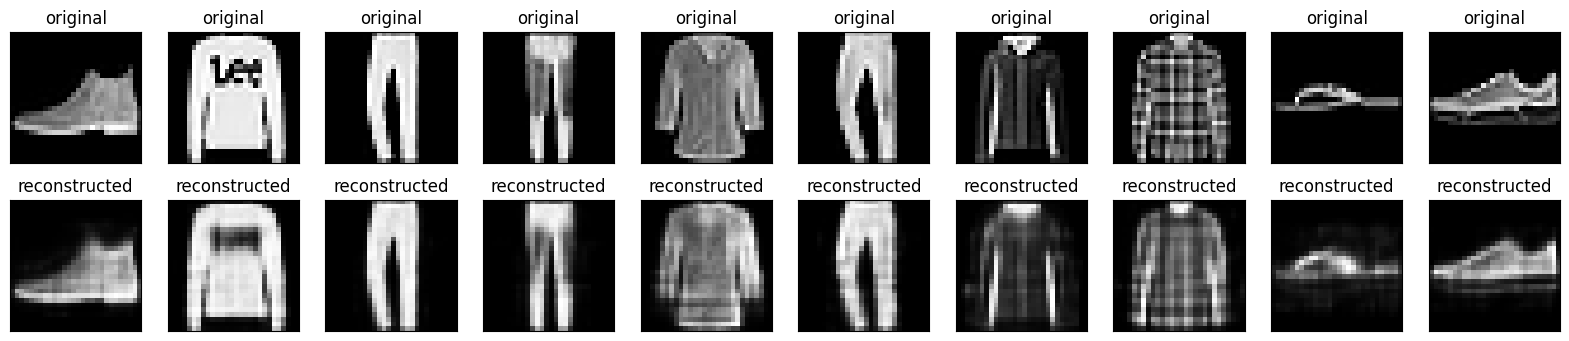

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

We observe how from the lower dimension reconstructed, it almost looks like a blurred out version.

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

But if you're using the original image as the target, how is that unsupervised learning? 

> Esto a lo que se refiere no es que vayamos a hacer un aprendizaje supervisado, como bien te puedes confundir. Nosotros vamos a hacer uso de nuestro dataset original de imagenes. Añadirle ruido, y pasarlo por nuestro auto-encoder. El cual reconstruirá la imagen.

> The objective is to predict a clean input from a noisy input. 

[Denoising Autoencoders](https://www.omdena.com/blog/denoising-autoencoders)

In [11]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# * Increase the dataset by one dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [13]:

noise_factor = 0.2

# * Add Gaussian noise to the training data
# ? -  tf.random.normal generates random values from a normal distribution
# ? - with a mean of 0 and standard deviation of 1
# ! - shape=x_train.shape ensures that the generated noise has the same shape as x_train
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# ? - Clip the values of the noisy training data to ensure they fall within the range [0, 1]
# ! - In this case, it ensures that values below 0 are set to 0 and values above 1 are set to 1
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Restricting the valid range of pixel values between 0 and 1 is important for several reasons, particularly in the context of image data processing and machine learning tasks:

Normalization: By restricting the pixel values to the range [0, 1], we normalize the data. 

Plot the noisy images.


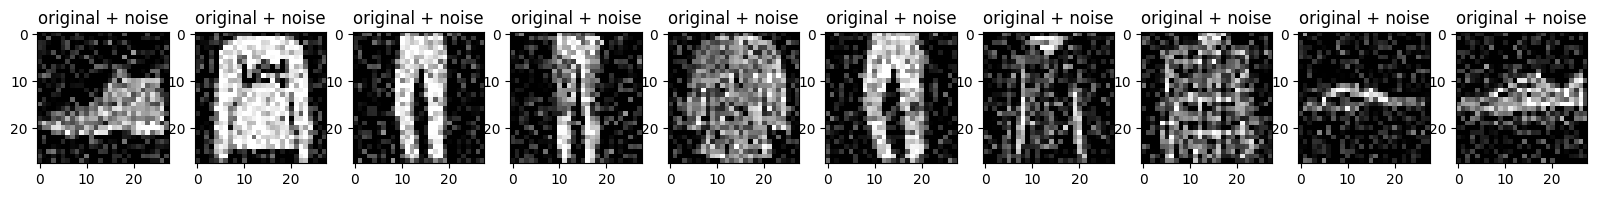

In [14]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [15]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      # ? - Input del autoencoder es una imagen de entrada de 28 x 28 - 1 canal. 
      # ? - the output of this layer will have 16 channels, where each channel corresponds to the output of one filter.
      layers.Input(shape=(28, 28, 1)),
      # ? - Aplica 16 filtros de 3x3 y después reduce la dimensión por la mitad
      # ? - the output of this layer will have 16 channels, where each channel corresponds to the output of one filter.
      # ! - Entonces reducimos el input a 16, y después aplicamos el stride, por ello el siguiente pasa a 8   
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      # ? - the output of this layer will have 16 channels, where each channel corresponds to the output of one filter. 
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      # * upsampling or transposed convolution, and it's key to reconstructing the input image from its encoded representation.
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

**Decoder:**
* _Filter with Kernel Size 3x3:_ This layer doesn't change the spatial dimensions due to the use of 'same' padding and a stride of 1 (the default, since it's not specified). Its primary purpose is to consolidate the 16 feature maps from the previous layer into a single feature map. This is because the original input images are grayscale (1 channel), so the final output needs to match this dimensionality.
* _Filters:_ Each filter is designed to detect specific types of features, such as edges, textures, or more complex patterns in deeper layers.

* _Activation='sigmoid':_ The sigmoid activation function is used here to ensure that the output values are normalized between 0 and 1, which is suitable for binary or grayscale image data, where 0 represents black and 1 represents white.

In [16]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [17]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10, # * Do we have to determine a minimum number of epochs?
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


1875/1875 [==============================] - 16s 9ms/step - loss: 0.0181 - val_loss: 0.0115
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [18]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [19]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [20]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

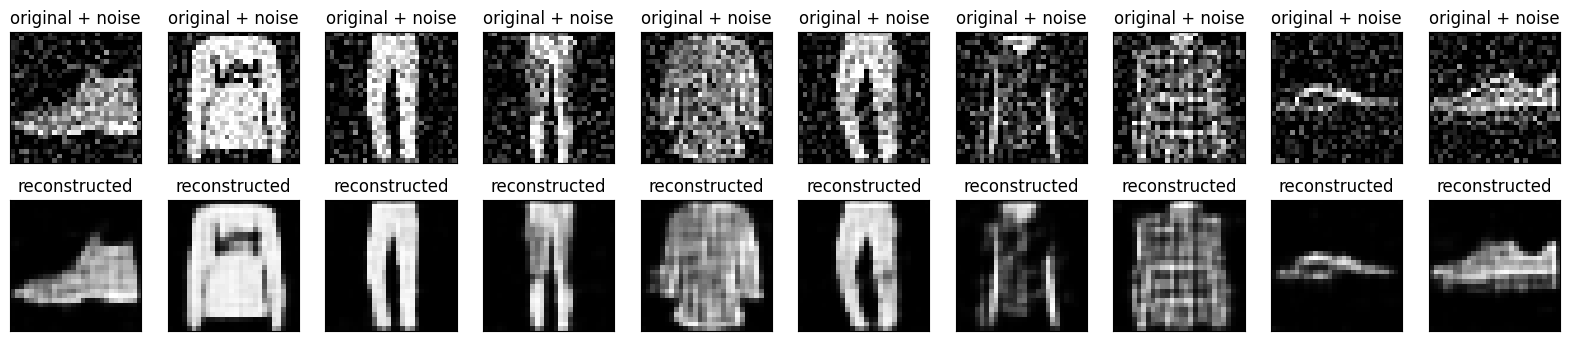

In [21]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


About dataset: http://www.timeseriesclassification.com/description.php?Dataset=ECG5000

* The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet.
* The data was pre-processed in two steps: 
  * (1) extract each heartbeat, 
  * (2) make each heartbeat equal length using interpolation.
* This dataset contains 5,000 Electrocardiograms, each with 140 data points. Here, we'll use a simplified version of the dataset. 
* Each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

In [22]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [23]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


## Attention! 

* Normalisation != Standardisation
* **Normalisation** fixes the rescales the data to a fixed range, typically [0,1] or [-1,1]
  * This technique is useful when you need to scale the features to a bounded interval. 
  * Useful when the feature distribution is unclear.
* **Standardization**, rescales data to have a mean of 0 and a standard deviation of 1, transforming it into a distribution with these properties. 
  * Typically will not affect on any data outliers. 
  * Useful when the feature distribution is consistent. 

In [24]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [25]:
train_labels = train_labels.astype(bool) # * Since they are 0 and 1, 0 -> False (Abnormal), 1 -> True (Normal)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

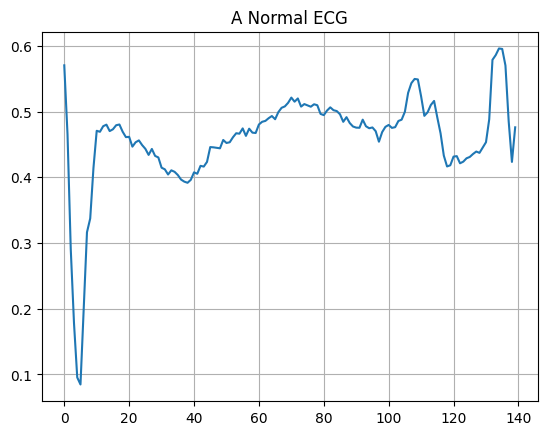

In [26]:
plt.grid()
# * We know that each ECG has 140 datapoints, which is why we arrange it as so and display it. 
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

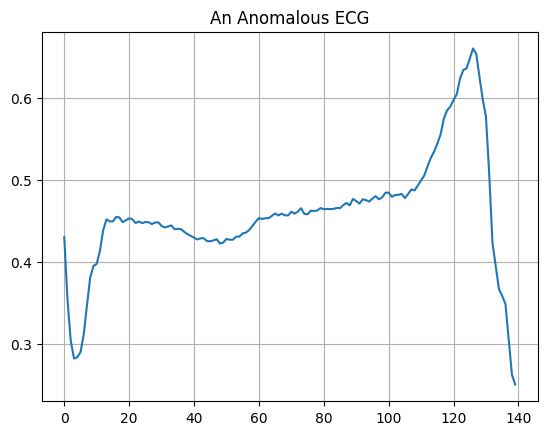

In [27]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [28]:
class AnomalyDetector(Model):
  # * Initialise it - Subclassing model
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    # * Sequential API -> Layered
    self.encoder = tf.keras.Sequential([
      # * It's curious, in this case we're not specifying the type of kernel, pooling or stride values, does it do it automatically?
      # ? - No input layer?
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")]) # * Sigmoid function since it's meant to be binary output

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [29]:
autoencoder.compile(optimizer='adam', loss='mae')

In [41]:
df = pd.DataFrame(normal_train_data)
df.shape

(2359, 140)

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [30]:
history = autoencoder.fit(normal_train_data, normal_train_data, # * Adjust it to fit what normal data looks like
          epochs=20, # * How have they decided which is the appropriate batch size and epoch number?
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)
# * Why would we be interested in having that as our validation data, how does that work? 

Epoch 1/20


5/5 [==============================] - 0s 19ms/step - loss: 0.0580 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0569 - val_loss: 0.0527
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0557 - val_loss: 0.0517
Epoch 4/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.0506
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0525 - val_loss: 0.0485
Epoch 6/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0485 - val_loss: 0.0473
Epoch 7/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0444 - val_loss: 0.0442
Epoch 8/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0403 - val_loss: 0.0430
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0368 - val_loss: 0.0410
Epoch 10/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0337 - val_loss: 0.0400
Epoch 11/20
5/5 [==============================] 

**How well does the model respond to data that diverge from the patterns it has been trained to recognize as normal?**

In this setup, the anomalies are essentially unseen patterns that the model has not encountered during the training phase. The underlying hypothesis is that the autoencoder will have a higher reconstruction error for these anomalous samples because they do not conform to the "normal" structure it learned. The higher the reconstruction error, the more likely the data is anomalous.

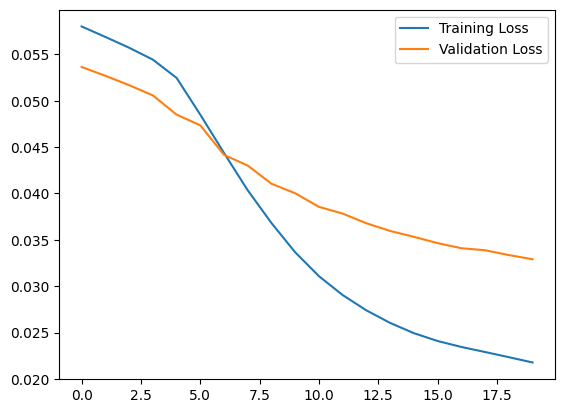

In [31]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous **if the reconstruction error is greater than one standard deviation from the normal training examples.** First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

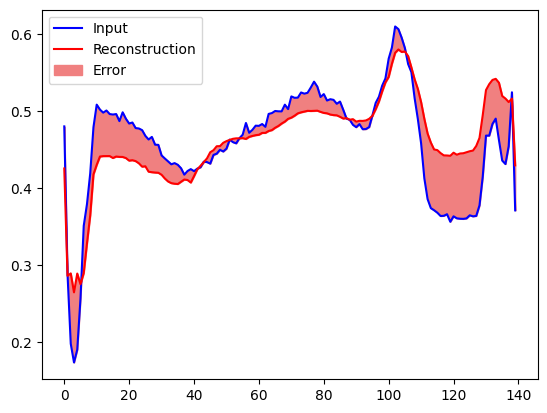

In [32]:
encoded_data = autoencoder.encoder(normal_test_data).numpy() # * Application of the entire encoder before we select the few ones. 
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

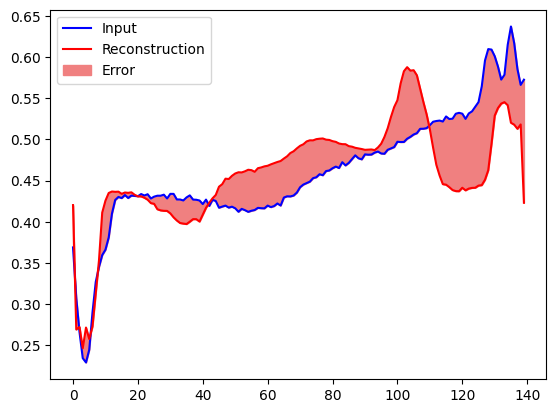

In [33]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

**Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold**. 

In this tutorial, **you will calculate the mean average error for normal examples from the training set**, then classify future examples as anomalous if the **reconstruction error is higher than one standard deviation from the training set.**


Plot the reconstruction error on normal ECGs from the training set

74/74 [==============================] - 0s 439us/step


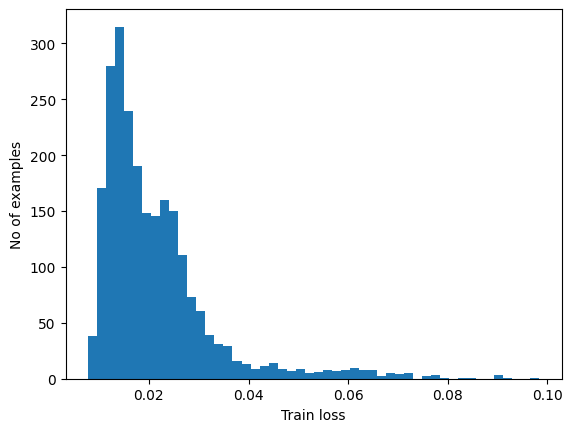

In [34]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data) # * Get a list of the errors produced when trying to reconstruct the normal data

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [35]:
threshold = np.mean(train_loss) + np.std(train_loss) # * Get the mean and add another single standard deviation to it. 
print("Threshold: ", threshold)

Threshold:  0.033166602


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

14/14 [==============================] - 0s 616us/step


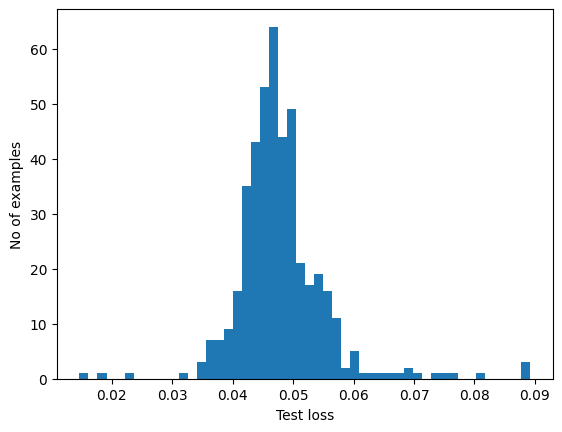

In [36]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [37]:
def predict(model, data, threshold):
  reconstructions = model(data) # * Pass the autoencoder model to reconstruct the input test data
  loss = tf.keras.losses.mae(reconstructions, data) # * Compute the mean absolute error, between the reconstructions and the original data
  return tf.math.less(loss, threshold) # * Compare the reconstruction to the threshold. If error < threshold, data point is normal (True), else false -> anomalus

def print_stats(predictions, labels): # * This labels and we compare with the predictions
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [38]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429
